# Celltype auto annotation with SCSA
Single-cell transcriptomics allows the analysis of thousands of cells in a single experiment and the identification of novel cell types, states and dynamics in a variety of tissues and organisms. Standard experimental protocols and analytical workflows have been developed to create single-cell transcriptomic maps from tissues.

This tutorial focuses on how to interpret this data to identify cell types, states, and other biologically relevant patterns with the goal of creating annotated cell maps.

Paper: [SCSA: A Cell Type Annotation Tool for Single-Cell RNA-seq Data](https://doi.org/10.3389/fgene.2020.00490)

Code: https://github.com/bioinfo-ibms-pumc/SCSA

Colab_Reproducibility：https://colab.research.google.com/drive/1BC6hPS0CyBhNu0BYk8evu57-ua1bAS0T?usp=sharing

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA can't be used in rare celltype annotations
  </p>
</div>

![scsa](https://www.frontiersin.org/files/Articles/524690/fgene-11-00490-HTML/image_m/fgene-11-00490-g001.jpg)

In [1]:
# !pip install omicverse
# !pip install torch_geometric
# !pip install pymde

**You must restart the program(ctrl+m+.) in order to import the accurate version of matplotlib.**

In [2]:
import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.5.7
scanpy version:1.9.6


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [3]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘write’: File exists


Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [4]:
adata = sc.read_10x_mtx(
    'data/CytAssist_11mm_FFPE_Human_Lung_Cancer_filtered_feature_bc_matrix/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True
)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-CytAssist_11mm_FFPE_Human_Lung_Cancer_filtered_feature_bc_matrix-filtered_feature_bc_matrix-matrix.h5ad


## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation.

But if you want to experience step-by-step preprocessing, we also provide more detailed preprocessing steps here, please refer to our [preprocess chapter](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess/) for a detailed explanation.

We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [5]:
#adata=ov.single.scanpy_lazy(adata)

#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

#Neighbourhood graph construction
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
sc.tl.leiden(adata)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 6195
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 17 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 8.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%
    Scrublet finished (0:00:06)
Cells retained after scrublet: 6191, 4 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower treshold, 

AnnData object with n_obs × n_vars = 672 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'leiden'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [6]:
scsa=ov.single.pySCSA(adata=adata, foldchange=1.5, pvalue=0.01, celltype='cancer', target='cancersea', tissue='All')

......Loading dataset from temp/pySCSA_2023_v2_plus.db


In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.

`rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`, if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`

In [7]:
anno=scsa.cell_anno(clustertype='leiden', cluster='all', rank_rep=True)

ranking genes
    finished (0:00:00)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 12611
Cluster 0 Gene number: 754
Other Gene number: 715
Cluster 1 Gene number: 1536
Other Gene number: 729
Cluster 10 Gene number: 928
Other Gene number: 699
Cluster 11 Gene number: 276
Other Gene number: 727
Cluster 2 Gene number: 594
Other Gene number: 700
Cluster 3 Gene number: 1213
Other Gene number: 686
Cluster 4 Gene number: 490
Other Gene number: 730
Cluster 5 Gene number: 905
Other Gene number: 715
Cluster 6 Gene number: 721
Other Gene number: 726
Cluster 7 Gene number: 6488
Other Gene number: 526
Cluster 8 Gene number: 150
Other Gene number: 733
Cluster 9 Gene number: 632
Other Gene number

We can query only the better annotated results

In [8]:
scsa.cell_auto_anno(adata,key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


We can also use `panglaodb` as target to annotate the celltype

In [9]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='cancer',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'

)

In [10]:
res = scsa.cell_anno(clustertype='leiden', cluster='all', rank_rep=True)

ranking genes
    finished (0:00:00)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 12611
Cluster 0 Gene number: 754
Other Gene number: 3447
Cluster 1 Gene number: 1536
Other Gene number: 3495
Cluster 10 Gene number: 928
Other Gene number: 3401
Cluster 11 Gene number: 276
Other Gene number: 3504
Cluster 2 Gene number: 594
Other Gene number: 3420
Cluster 3 Gene number: 1213
Other Gene number: 3287
Cluster 4 Gene number: 490
Other Gene number: 3498
Cluster 5 Gene number: 905
Other Gene number: 3447
Cluster 6 Gene number: 721
Other Gene number: 3468
Cluster 7 Gene number: 6488
Other Gene number: 2721
Cluster 8 Gene number: 150
Other Gene number: 3517
Cluster 9 Gene number: 632
Other 

We can query only the better annotated results

In [11]:
scsa.cell_anno_print()

Cluster:0	Cell_type:Smooth Muscle Cells|Fibroblasts	Z-score:4.013|2.612
Cluster:1	Cell_type:Neurons|Interneurons	Z-score:3.453|3.301
Cluster:2	Cell_type:Fibroblasts|Endothelial Cells	Z-score:4.889|3.569
Cluster:3	Cell_type:Pulmonary Alveolar Type II Cells|Endothelial Cells	Z-score:4.26|2.77
Cluster:4	Cell_type:Smooth Muscle Cells|Cardiomyocytes	Z-score:4.279|2.833
Cluster:5	Cell_type:Pulmonary Alveolar Type II Cells|Epithelial Cells	Z-score:5.102|3.599
Cluster:6	Cell_type:Macrophages|Smooth Muscle Cells	Z-score:2.831|2.641
Cluster:7	Cell_type:Neurons|Interneurons	Z-score:4.156|3.791
Cluster:8	Cell_type:Enteroendocrine Cells|Delta Cells	Z-score:3.485|3.344
Cluster:9	Cell_type:Neurons|Epithelial Cells	Z-score:3.133|2.586
Cluster:10	Cell_type:Macrophages|Dendritic Cells	Z-score:4.351|3.322
Cluster:11	Cell_type:Endothelial Cells (Aorta)|Smooth Muscle Cells	Z-score:3.521|3.172


In [12]:
scsa.cell_auto_anno(adata, key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


Here, we introduce the dimensionality reduction visualisation function `ov.utils.embedding`, which is similar to `scanpy.pl.embedding`, except that when we set `frameon='small'`, we scale the axes to the bottom-left corner and scale the colourbar to the bottom-right corner.

- adata: the anndata object
- basis: the visualized embedding stored in adata.obsm
- color: the visualized obs/var
- legend_loc: the location of legend, if you set None, it will be visualized in right.
- frameon: it can be set `small`, False or None
- legend_fontoutline: the outline in the text of legend.
- palette: Different categories of colours, we have a number of different colours preset in omicverse, including `ov.utils.palette()`, `ov.utils.red_color`, `ov.utils.blue_color`, `ov.utils.green_color`, `ov. utils.orange_color`. The preset colours can help you achieve a more beautiful visualisation.

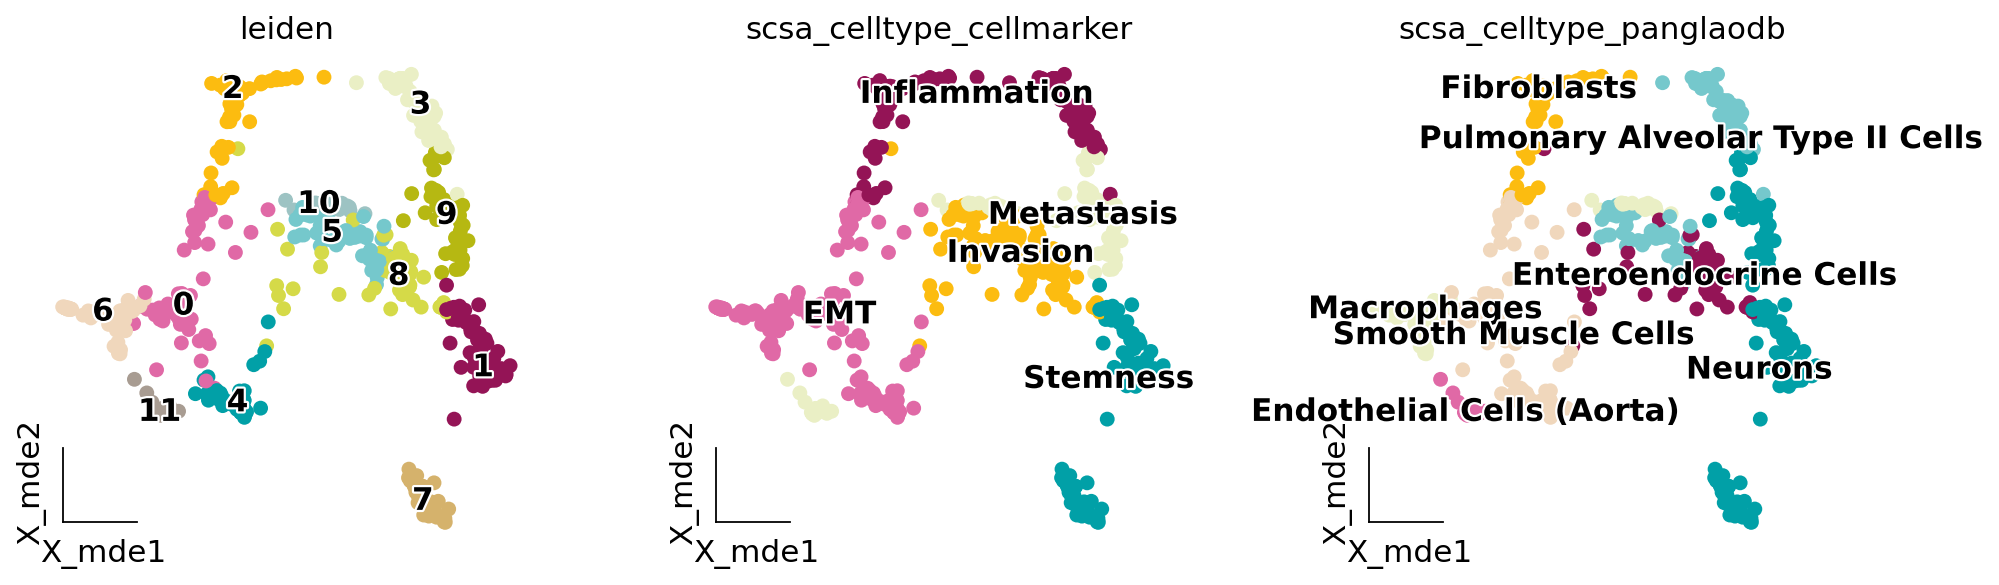

In [13]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['leiden','scsa_celltype_cellmarker','scsa_celltype_panglaodb'],
                   legend_loc='on data',
                   frameon='small',
                   legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

If you want to draw stacked histograms of cell type proportions, you first need to colour the groups you intend to draw using `ov.utils.embedding`. Then use `ov.utils.plot_cellproportion` to specify the groups you want to plot, and you can see a plot of cell proportions in the different groups

In [14]:
adata.var

,gene_ids,feature_types,mt,n_cells,percent_cells,robust,mean,var,residual_variances,highly_variable_rank,highly_variable_features
HES4,ENSG00000188290,Gene Expression,False,513,76.339286,True,2.105655,4.288373,2.776391,1387.0,True
ISG15,ENSG00000187608,Gene Expression,False,387,57.589286,True,1.739583,29.516285,10.242128,273.0,True
TNFRSF4,ENSG00000186827,Gene Expression,False,103,15.327381,True,0.206845,0.337181,2.330839,1840.0,True
MXRA8,ENSG00000162576,Gene Expression,False,563,83.779762,True,3.714286,13.909304,5.307031,615.0,True
MMP23B,ENSG00000189409,Gene Expression,False,375,55.803571,True,1.056548,1.657006,2.879121,1316.0,True
...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,True,672,100.000000,True,85.092262,12676.763457,5.925154,553.0,True
MT-ND4,ENSG00000198886,Gene Expression,True,672,100.000000,True,125.516369,30899.183040,6.835574,470.0,True
MT-ND5,ENSG00000198786,Gene Expression,True,671,99.851190,True,31.938988,1665.872576,2.438887,1702.0,True
MT-ND6,ENSG00000198695,Gene Expression,True,670,99.702381,True,22.796131,565.128271,2.332141,1838.0,True


In [15]:
import numpy as np
import pandas as pd

### Will be removed to be Case vs. Control

In [27]:
# Step 3: Define a mask to select half of the rows
mask = np.random.rand(adata.shape[0]) < 0.5

# Step 4: Create a new column in the Anndata object to mark the groups
adata.obs['group'] = pd.Categorical(['Control' if m else 'Stim' for m in mask])

In [28]:
adata.obs

,nUMIs,mito_perc,detected_genes,cell_complexity,doublet_score,predicted_doublet,passing_mt,passing_nUMIs,passing_ngenes,n_genes,leiden,scsa_celltype_cellmarker,scsa_celltype_panglaodb,group
AACACTCGTGAGCTTC-1,3171.0,0.042258,2143,0.675812,0.331378,False,True,True,True,2142,1,Stemness,Neurons,Control
AACAGGCCAGGCCGCT-1,17140.0,0.019603,7386,0.430922,0.051216,False,True,True,True,7386,10,Metastasis,Macrophages,Stim
AACATAGGAGGCGTCC-1,11983.0,0.018610,5564,0.464324,0.040088,False,True,True,True,5564,2,Inflammation,Fibroblasts,Stim
AACCAACAATCGGTAC-1,6336.0,0.038984,3634,0.573548,0.075503,False,True,True,True,3634,8,Invasion,Enteroendocrine Cells,Stim
AACCTCCGTAATTCTG-1,25271.0,0.018836,7326,0.289898,0.049406,False,True,True,True,7326,0,EMT,Smooth Muscle Cells,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTAACGCATGGATA-1,20629.0,0.012701,6485,0.314363,0.010417,False,True,True,True,6485,0,EMT,Smooth Muscle Cells,Stim
TGTTACCGAGCAATGA-1,38594.0,0.028165,9360,0.242525,0.057202,False,True,True,True,9360,5,Invasion,Pulmonary Alveolar Type II Cells,Control
TGTTCACCAAGAACGA-1,23005.0,0.011997,6637,0.288502,0.008792,False,True,True,True,6637,0,EMT,Smooth Muscle Cells,Stim
TGTTCGATCTAAGGCG-1,36500.0,0.035315,9271,0.254000,0.121655,False,True,True,True,9271,1,Stemness,Neurons,Control


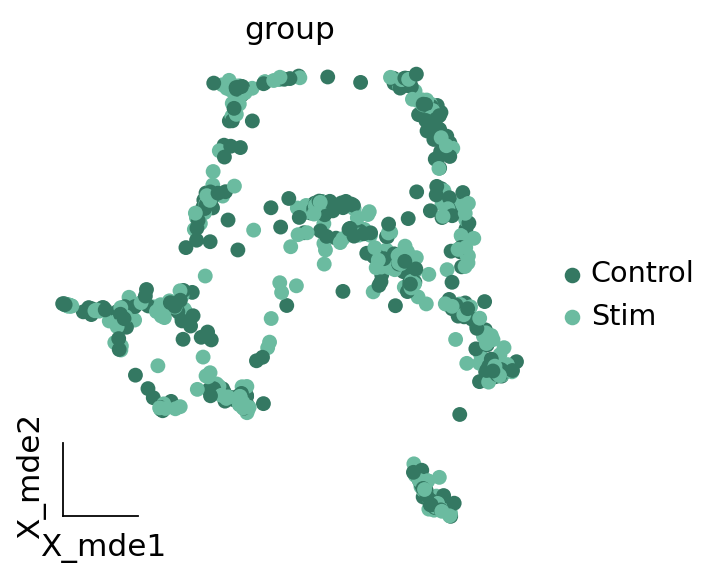

In [29]:
#Colored
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['group'],
                   frameon='small',
                   legend_fontoutline=2,
                   palette=ov.utils.blue_palette(),
                  )

(<Figure size 320x480 with 1 Axes>,
 <AxesSubplot: xlabel='group', ylabel='Cells per Stage'>)

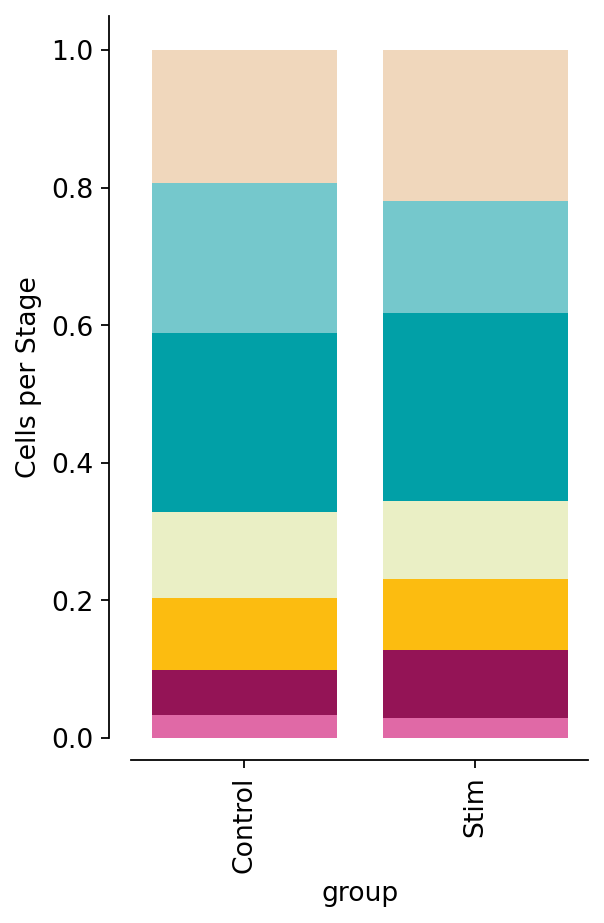

In [30]:
ov.utils.plot_cellproportion(adata=adata,
                             celltype_clusters='scsa_celltype_panglaodb',
                             visual_clusters='group',
                             visual_name='group',
                             figsize=(4, 6))

Of course, we also provide another downscaled visualisation of the graph using `ov.utils.plot_embedding_celltype`

(<Figure size 800x480 with 2 Axes>,
 [<AxesSubplot: xlabel='X_mde1', ylabel='X_mde2'>, <AxesSubplot: >])

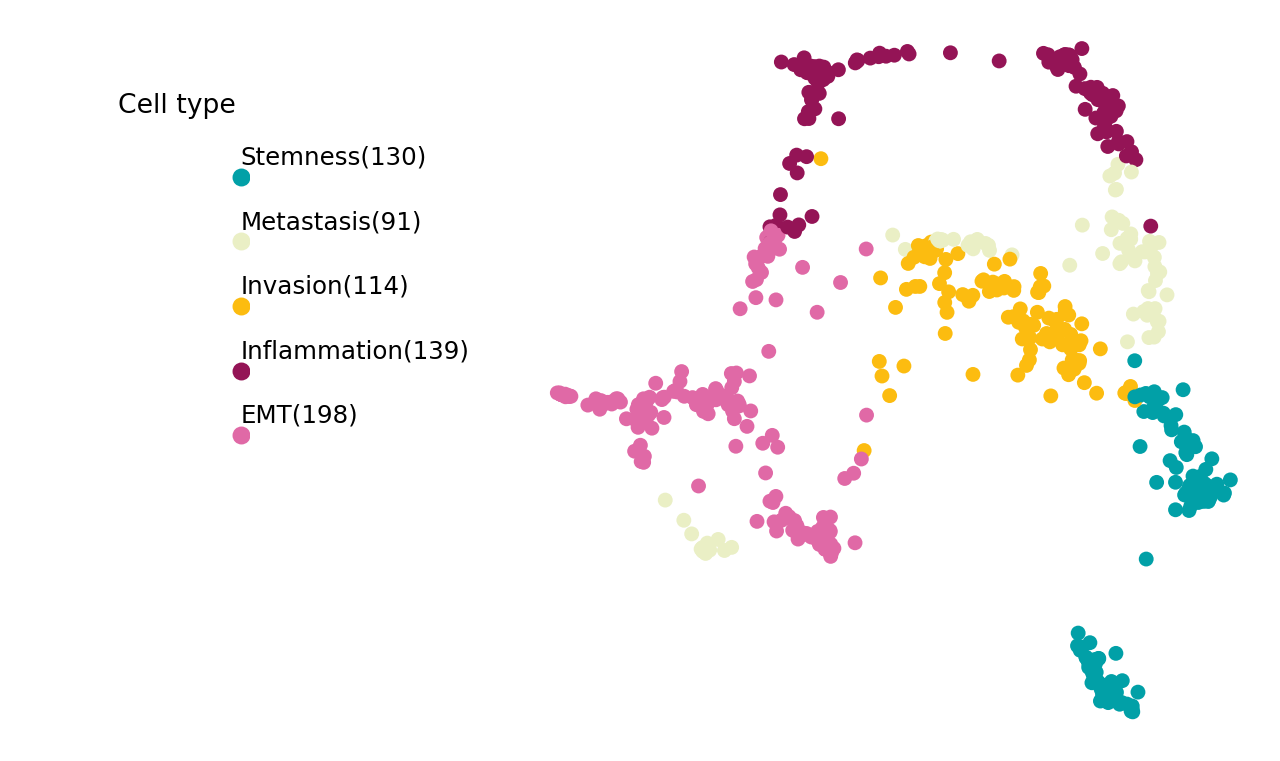

In [31]:
ov.utils.plot_embedding_celltype(adata,
                                 figsize=(10, 6),
                                 basis='X_mde',
                                 celltype_key='scsa_celltype_cellmarker',
                                 title='            Cell type',
                                 celltype_range=(2,6),
                                 embedding_range=(4,10),
                                )

We calculated the ratio of observed to expected cell numbers (Ro/e) for each cluster in different tissues to quantify the tissue preference of each cluster (Guo et al., 2018; Zhang et al., 2018). The expected cell num- bers for each combination of cell clusters and tissues were obtained from the chi-square test. One cluster was identified as being enriched in a specific tissue if Ro/e>1.

The Ro/e function was wrote by `Haihao Zhang`.

In [32]:
roe=ov.utils.roe(adata, sample_key='group', cell_type_key='scsa_celltype_panglaodb')

chi2: 5.695365731982157, dof: 6, pvalue: 0.45816541323121385
P-value is greater than 0.05, there is no statistical significance


Text(0.5, 1.0, 'Ro/e')

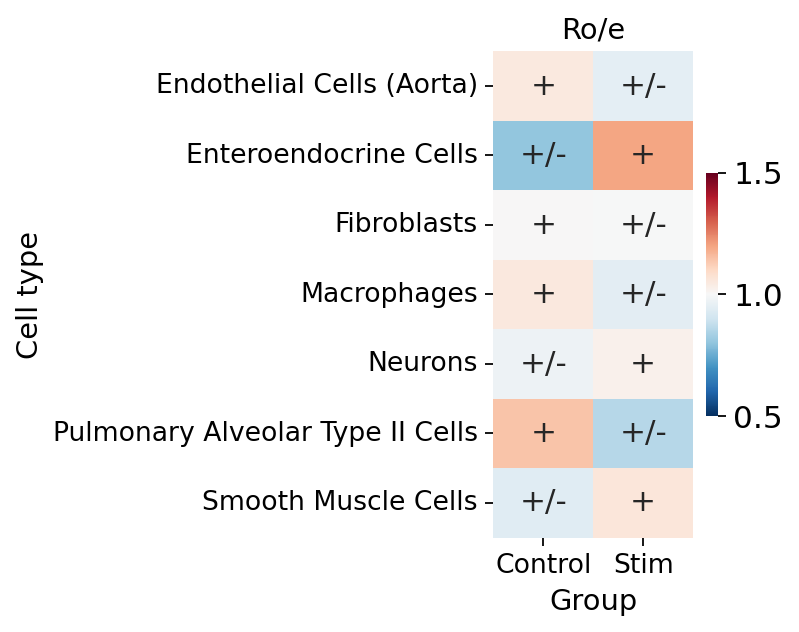

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,4))

transformed_roe = roe.copy()
transformed_roe = transformed_roe.applymap(
    lambda x: '+++' if x >= 2 else ('++' if x >= 1.5 else ('+' if x >= 1 else '+/-')))

sns.heatmap(roe, annot=transformed_roe, cmap='RdBu_r', fmt='',
            cbar=True, ax=ax,vmin=0.5,vmax=1.5,cbar_kws={'shrink':0.5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Group',fontsize=13)
plt.ylabel('Cell type',fontsize=13)
plt.title('Ro/e',fontsize=13)

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [34]:
scsa.get_model_tissue()

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          

In [35]:
adata.obs

,nUMIs,mito_perc,detected_genes,cell_complexity,doublet_score,predicted_doublet,passing_mt,passing_nUMIs,passing_ngenes,n_genes,leiden,scsa_celltype_cellmarker,scsa_celltype_panglaodb,group
AACACTCGTGAGCTTC-1,3171.0,0.042258,2143,0.675812,0.331378,False,True,True,True,2142,1,Stemness,Neurons,Control
AACAGGCCAGGCCGCT-1,17140.0,0.019603,7386,0.430922,0.051216,False,True,True,True,7386,10,Metastasis,Macrophages,Stim
AACATAGGAGGCGTCC-1,11983.0,0.018610,5564,0.464324,0.040088,False,True,True,True,5564,2,Inflammation,Fibroblasts,Stim
AACCAACAATCGGTAC-1,6336.0,0.038984,3634,0.573548,0.075503,False,True,True,True,3634,8,Invasion,Enteroendocrine Cells,Stim
AACCTCCGTAATTCTG-1,25271.0,0.018836,7326,0.289898,0.049406,False,True,True,True,7326,0,EMT,Smooth Muscle Cells,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTAACGCATGGATA-1,20629.0,0.012701,6485,0.314363,0.010417,False,True,True,True,6485,0,EMT,Smooth Muscle Cells,Stim
TGTTACCGAGCAATGA-1,38594.0,0.028165,9360,0.242525,0.057202,False,True,True,True,9360,5,Invasion,Pulmonary Alveolar Type II Cells,Control
TGTTCACCAAGAACGA-1,23005.0,0.011997,6637,0.288502,0.008792,False,True,True,True,6637,0,EMT,Smooth Muscle Cells,Stim
TGTTCGATCTAAGGCG-1,36500.0,0.035315,9271,0.254000,0.121655,False,True,True,True,9271,1,Stemness,Neurons,Control


In [37]:
# List of Scanpy methods for DGE analysis
methods = ['t-test', 'wilcoxon', 'logreg', 't-test_overestim_var']

# Create an empty DataFrame to store results
all_results = pd.DataFrame()

# Perform differential gene expression analysis for each cluster using different methods
for cluster in adata.obs['leiden'].unique():
    # celltype = adata.obs[adata.obs.leiden == cluster]
    cluster_results = pd.DataFrame()
    # if cluster == '0':
        # Subset the data for the current cluster
    cluster_data = adata[adata.obs['leiden'] == cluster]
    
    # Print the cluster information
    # print(f"\nClusteadata.obs[adata.obs.leiden == '0']r: {cluster}")

    # Perform differential gene expression analysis for each method
    for method in methods:
        sc.tl.rank_genes_groups(cluster_data, groupby='group', method=method)

        # print(cluster_data.uns['rank_genes_groups'].keys())
        # Retrieve the statistical results as a DataFrame
        name_results = pd.DataFrame(cluster_data.uns['rank_genes_groups']['names'])
        scores_results = pd.DataFrame(cluster_data.uns['rank_genes_groups']['scores'])
        # pvals_adj_results = pd.DataFrame(cluster_data.uns['rank_genes_groups']['pvals_adj'])
        # logfoldchanges_results = pd.DataFrame(cluster_data.uns['rank_genes_groups']['logfoldchanges'])

        # name_results = name_results.rename(columns={'A': 'Control', 'B': 'Case'})
        scores_results = scores_results.rename(columns={'Control': 'Control Score', 'Stim': 'Stim Score'})
        # pvals_adj_results = pvals_adj_results.rename(columns={'A': 'A pval adj', 'B': 'B pval adj'})
        # logfoldchanges_results = logfoldchanges_results.rename(columns={'A': 'A logfoldchanges', 'B': 'B logfoldchanges'})
        
        # Add a column for the method and cluster
        name_results['method'] = method
        name_results['cluster'] = cluster
        
        results = pd.concat([name_results, scores_results], axis=1)
        print(f'Cluster: {cluster}\n\tMethod: {method}')
        
        # sc.pl.rank_genes_groups_tracksplot(cluster_data, dendrogram=False, n_genes=5)
        cluster_results = pd.concat([cluster_results, results], axis=0)
        cluster_results['CellType'] = cluster_data.obs['scsa_celltype_panglaodb'][0]

    all_results = pd.concat([all_results, cluster_results], axis=0)
    
# Save the combined results to a CSV file
all_results.to_csv('differential_expression_results.csv', index=False)

ranking genes
    finished (0:00:00)
Cluster: 1
	Method: t-test
ranking genes
    finished (0:00:00)
Cluster: 1
	Method: wilcoxon
ranking genes
    finished (0:00:00)
Cluster: 1
	Method: logreg
ranking genes
    finished (0:00:00)
Cluster: 1
	Method: t-test_overestim_var
ranking genes
    finished (0:00:00)
Cluster: 10
	Method: t-test
ranking genes
    finished (0:00:00)
Cluster: 10
	Method: wilcoxon
ranking genes
    finished (0:00:00)
Cluster: 10
	Method: logreg
ranking genes
    finished (0:00:00)
Cluster: 10
	Method: t-test_overestim_var
ranking genes
    finished (0:00:00)
Cluster: 2
	Method: t-test
ranking genes
    finished (0:00:00)
Cluster: 2
	Method: wilcoxon
ranking genes
    finished (0:00:00)
Cluster: 2
	Method: logreg
ranking genes
    finished (0:00:00)
Cluster: 2
	Method: t-test_overestim_var
ranking genes
    finished (0:00:00)
Cluster: 8
	Method: t-test
ranking genes
    finished (0:00:00)
Cluster: 8
	Method: wilcoxon
ranking genes
    finished (0:00:00)
Cluster: 8
	M

In [46]:
all_results[all_results['Control'] == 'KCTD12']

,Control,Stim,method,cluster,Control Score,Stim Score,CellType
1317,KCTD12,FGR,t-test,1,2.102946,0.904027,Neurons
3613,KCTD12,FANCE,wilcoxon,1,1.169277,0.216533,Neurons
14736,KCTD12,NaN,logreg,1,-0.003152,NaN,Neurons
1213,KCTD12,SOX13,t-test_overestim_var,1,2.201785,0.935903,Neurons
9198,KCTD12,SPATA46,t-test,10,-0.271930,0.219310,Macrophages
10126,KCTD12,TXNDC2,wilcoxon,10,-0.213201,0.000000,Macrophages
12599,KCTD12,NaN,logreg,10,-0.000707,NaN,Macrophages
9145,KCTD12,FHAD1,t-test_overestim_var,10,-0.287829,0.212580,Macrophages
12562,KCTD12,ENPP3,t-test,2,-0.569290,-0.463780,Fibroblasts
7944,KCTD12,CRLF3,wilcoxon,2,0.064604,0.070477,Fibroblasts
